In [6]:
import os
os.chdir('../')

In [101]:
import pandas as pd
from pathlib import Path
import numpy as np
import sys
import glob
import warnings
import random
from pandarallel import pandarallel
from source.lib.JMSLab import autofill
from source.lib.helpers import ExportTable, AddToTableList
import ast
import json 
import db_dtypes 
import datetime
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pandarallel.initialize(progress_bar = True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# GitHub Data

- Issue
- Pull Request
- Release
- commit data (PRs, pushes)
- issue PR links

In [40]:
def ReadPrIssueData(file_dirs, data_cols):
    df_final = pd.DataFrame(columns = data_cols)
    for file in file_dirs:
        df_part = pd.read_csv(file, nrows = 1)
        df_part_cols = [col for col in data_cols if col in df_part.columns]
        df_part = pd.read_csv(file, usecols = df_part_cols)
        df_final = pd.concat([df_final, df_part]).drop_duplicates()

    df_final = AddDates(df_final)

    return df_final

def AddDates(df):
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['date'] = df.parallel_apply(lambda x: f"{x['created_at'].year}-{x['created_at'].month}", axis = 1)

    return df


In [41]:
pr_data_indir = glob.glob('drive/output/scrape/extract_github_data/pull_request_data/*2022_1.csv')
pr_data_indir.extend(glob.glob('drive/output/scrape/extract_github_data/pull_request_review_data/*2022_1.csv'))
pr_data_indir.extend(glob.glob('drive/output/scrape/extract_github_data/pull_request_review_comment_data/*2022_1.csv'))
pr_cols = ['type','created_at','repo_id','repo_name','actor_id','actor_login','pr_number', 'pr_title',
           'pr_body', 'pr_action','pr_merged_by_id','pr_merged_by_type','pr_label', 'pr_review_action',
           'pr_review_id','pr_review_state', 'pr_review_body', 'pr_review_comment_body']
df_pr = ReadPrIssueData(pr_data_indir, pr_cols)

issue_data_indir = glob.glob('drive/output/scrape/extract_github_data/issue_data/*2022_1.csv')
issue_data_indir.extend(glob.glob('drive/output/scrape/extract_github_data/issue_comment_data/*2022_1.csv'))
issue_cols = ['type','created_at','repo_id','repo_name','actor_id','actor_login','issue_number', 'issue_body','issue_title',
              'issue_action','issue_state', 'issue_comment_id', 'issue_user_id', 'issue_comment_body']
df_issue = ReadPrIssueData(issue_data_indir, issue_cols)

In [67]:
release_indir = glob.glob('drive/output/scrape/extract_github_data/release_data/*2022_1.csv')
df_release = pd.concat([pd.read_csv(file, index_col = 0) for file in release_indir])

In [84]:
df_pr_commits = pd.read_parquet(glob.glob('drive/output/scrape/collect_commits/pr/*.parquet')[0])
df_push_commits = pd.read_parquet(glob.glob('drive/output/scrape/collect_commits/push/*.parquet')[0])

push_id_cols = ['repo_name','push_id']
pr_id_cols = ['repo_name','pr_number']
commit_cols = ['commit sha','commit author name','commit author email',
                       'committer name','commmitter email','commit message','commit additions',
                       'commit deletions','commit changes total','commit files changed count',
                       'commit file changes','commit time']

### Issues

In [44]:
df_issue.query('type == "IssuesEvent" & issue_action == "opened"').head(1)

,type,created_at,repo_id,repo_name,actor_id,actor_login,issue_number,issue_body,issue_title,issue_action,issue_state,issue_comment_id,issue_user_id,issue_comment_body,date
0,IssuesEvent,2022-01-13 18:34:05+00:00,1446467,pypa/pip,5459618,NAThompson,10793,### What's the problem this feature will solve...,More information about *why* a wheel is not su...,opened,open,NaN,5459618,NaN,2022-1


In [48]:
# note: issue comment text is missing, need to either requery BQ or scrape
df_issue.query('type == "IssueCommentEvent"').head(1)

,type,created_at,repo_id,repo_name,actor_id,actor_login,issue_number,issue_body,issue_title,issue_action,issue_state,issue_comment_id,issue_user_id,issue_comment_body,date
0,IssueCommentEvent,2022-01-20 17:07:39+00:00,72523920,cupy/cupy,8596659,chaithyagr,3202,NaN,NaN,NaN,NaN,1017725062,8596659,NaN,2022-1


### Pull Requests

In [53]:
df_pr.query('type == "PullRequestEvent" & pr_action == "opened"').head(1)

,type,created_at,repo_id,repo_name,actor_id,actor_login,pr_number,pr_title,pr_body,pr_action,pr_merged_by_id,pr_merged_by_type,pr_label,pr_review_action,pr_review_id,pr_review_state,pr_review_body,pr_review_comment_body,date
15167,PullRequestEvent,2022-01-16 23:55:24+00:00,72311399,epsy/od,685865,epsy,2,NaN,NaN,opened,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,2022-1


In [55]:
df_pr.query('type == "PullRequestEvent" & pr_action == "closed" & ~pr_merged_by_id.isna()').head(1)

,type,created_at,repo_id,repo_name,actor_id,actor_login,pr_number,pr_title,pr_body,pr_action,pr_merged_by_id,pr_merged_by_type,pr_label,pr_review_action,pr_review_id,pr_review_state,pr_review_body,pr_review_comment_body,date
0,PullRequestEvent,2022-01-30 16:53:56+00:00,1446467,pypa/pip,3275593,pradyunsg,10844,NaN,NaN,closed,3275593.0,User,['type: bug' 'C: finder'],NaN,NaN,NaN,NaN,NaN,2022-1


In [61]:
df_pr.query('type == "PullRequestReviewEvent" & pr_review_body.isna()').head(1)

,type,created_at,repo_id,repo_name,actor_id,actor_login,pr_number,pr_title,pr_body,pr_action,pr_merged_by_id,pr_merged_by_type,pr_label,pr_review_action,pr_review_id,pr_review_state,pr_review_body,pr_review_comment_body,date
0,PullRequestReviewEvent,2022-01-21 08:28:06+00:00,32181539,pypa/flit,3275593,pradyunsg,516,flit_core: refactor path handling to use pathlib,This should make path handling easier/cleaner ...,NaN,NaN,NaN,NaN,created,859230412,changes_requested,NaN,NaN,2022-1


In [62]:
df_pr.query('type == "PullRequestReviewCommentEvent"').head(1)

,type,created_at,repo_id,repo_name,actor_id,actor_login,pr_number,pr_title,pr_body,pr_action,pr_merged_by_id,pr_merged_by_type,pr_label,pr_review_action,pr_review_id,pr_review_state,pr_review_body,pr_review_comment_body,date
0,PullRequestReviewCommentEvent,2022-01-07 18:21:28+00:00,10068798,gcovr/gcovr,40258682,Spacetown,350,Added decision coverage to HTML output,"Hello everybody,\r\n\r\nmy company is active i...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I'll improve the JSON data model with the type...,2022-1


### Releases

In [71]:
df_release.head(1)

,type,created_at,repo_id,repo_name,actor_id,actor_login,org_id,org_login,release_action,release_tag_name,release_name,release_body
0,ReleaseEvent,2022-01-14 09:03:54+00:00,8503407,silx-kit/fabio,1018880,kif,14869885.0,silx-kit,published,v0.13.0,FabIO-0.13.0,Changelog:\r\n\r\n- Allow files to be larger t...


### Commits

In [88]:
df_pr_commits.head(1)[pr_id_cols + commit_cols]

,repo_name,pr_number,commit sha,commit author name,commit author email,committer name,commmitter email,commit message,commit additions,commit deletions,commit changes total,commit files changed count,commit file changes,commit time
,,,,,,,,,,,,,,
0,uiri/toml,29,8ffbbe0dacee8476447eefeb7cd50de4cb573a68,José Armando García Sancio,jsancio@gmail.com,José Armando García Sancio,jsancio@gmail.com,Remove None values when dumping Mapping\n,4.0,2.0,6.0,1.0,"[{'file': 'toml.py', 'additions': 4, 'deletion...",1.422540e+09


In [89]:
df_push_commits.head(1)[push_id_cols + commit_cols]

,repo_name,push_id,commit sha,commit author name,commit author email,committer name,commmitter email,commit message,commit additions,commit deletions,commit changes total,commit files changed count,commit file changes,commit time
0,ateliedocodigo/py-healthcheck,1518492989,86b9e2a849e1afb0ad0a8bb144f42aa7e26aefbf,Luis Fernando Gomes,dev@luiscoms.com.br,GitHub,noreply@github.com,Tornado support (#1)\n\n* Update README.md\r\n...,844.0,493.0,1337.0,23.0,"[{'file': '.editorconfig', 'additions': 12, 'd...",1.485285e+09


# Committers profiles
- Can be used for linkedin merging
- also has emails that can be used for corporate affiliation imputation

In [30]:
df_committers = pd.read_csv(
    'drive/output/scrape/link_committers_profile/committers_info.csv', index_col = 0).drop_duplicates()
df_committers = df_committers[['name','email','user_type','committer_info']]
df_committers['committer_info'] = df_committers['committer_info'].apply(lambda x: ast.literal_eval(x) if not pd.isnull(x) else x)

In [36]:
print(f"% of unmatchable contributors: {np.mean(df_committers['committer_info'].isna()):.2f}")

% of unmatchable contributors: 0.18


In [37]:
df_committers

,name,email,user_type,committer_info
0,Mike Shriver,mshriver@redhat.com,author,"[mshriver, 21315076, User, False]"
2,zeta83,ezequiel.aurtenechea@gmail.com,author,"[ezenechea, 448689, User, False]"
3,Andrzej Mateja,mateja.and@gmail.com,author,"[amateja, 9973037, User, False]"
5,Stanislav Lobanov,asyncee@users.noreply.github.com,author,"[jungornti, 10721388, User, False]"
7,Gaurav Arora,gaurav.arora0403@gmail.com,author,"[gauravv7, 11949916, User, False]"
...,...,...,...,...
398538,SimpleITK Topic Stage,kwrobot@kitware.com,committer,"[kwrobot, 489000, User, False]"
398540,Kitware Robot,kwrobot@kitware.com,committer,"[kwrobot, 489000, User, False]"
398542,Brian Price,brian.price@localhost.localdomain,committer,NaN
398543,unknown,Andrew.Walters@viasat.com,committer,NaN


# Project Data
- scorecard (mostly dependency management, but also links to some computer security known issues)
- truckfactor (do I want to get %'s..?)
- package downloads (do I need to do all version types? what about installer types?)
  - show graph of releases from way back maybe? to show that downloads are informative

### Scorecard

In [130]:
df_scorecard = pd.read_csv(glob.glob('drive/output/scrape/get_weekly_scorecard_data/scorecard/*.csv')[0],index_col = 0).T
df_scorecard

,time,commit_sha,date,week,year,scorecard_data
0,1692313877,8d720aa7bacdd9d1c28b9ba6de093ffb6399c2bd,2023-08-17 23:11:17,33,2023,"{'date': '2024-11-07T03:57:58-06:00', 'repo': ..."
1,1612816386,57301e22e8039e5f370ec47bca577db60844aa32,2021-02-08 20:33:06,6,2021,"{'date': '2024-11-07T03:58:01-06:00', 'repo': ..."
2,1595477478,98b2655dcd086a62c905acd4a6ec3d7b9436368d,2020-07-23 04:11:18,30,2020,"{'date': '2024-11-07T03:58:04-06:00', 'repo': ..."
3,1589994594,449f54d071ed5dffb5234e57958d6cbbea7b7088,2020-05-20 17:09:54,21,2020,"{'date': '2024-11-07T03:58:07-06:00', 'repo': ..."
4,1568522542,b099a137fdb0b7ab0aaaf1c9be293baaeceaef29,2019-09-15 04:42:22,37,2019,"{'date': '2024-11-07T03:58:15-06:00', 'repo': ..."
5,1564595451,428393904efa00ffa3ece4f0d2189d14a27d0639,2019-07-31 17:50:51,31,2019,"{'date': '2024-11-07T03:58:21-06:00', 'repo': ..."
6,1562108970,3b72085bc787113c44b0ccf32fa5a4e49234c457,2019-07-02 23:09:30,27,2019,"{'date': '2024-11-07T03:58:24-06:00', 'repo': ..."
7,1559944677,d303777157f4ce87efe61974213d81484dfcd10d,2019-06-07 21:57:57,23,2019,"{'date': '2024-11-07T03:58:29-06:00', 'repo': ..."
8,1559067585,a5895f74971c33bcf379988f4e4d78b7e49dc4bd,2019-05-28 18:19:45,22,2019,"{'date': '2024-11-07T03:58:33-06:00', 'repo': ..."
9,1550169320,99497c914ff842bb2e16ff475a3aec6f3ab5324f,2019-02-14 18:35:20,7,2019,"{'date': '2024-11-07T03:58:37-06:00', 'repo': ..."


In [136]:
# some notes
# have to determine for myself which ones matter most

ast.literal_eval(df_scorecard['scorecard_data'].head(1).values[0])

{'date': '2024-11-07T03:57:58-06:00',
 'repo': {'name': 'Fryuni/easygoogle',
  'commit': '8d720aa7bacdd9d1c28b9ba6de093ffb6399c2bd'},
 'scorecard': {'version': 'v5.0.0',
  'commit': 'ea7e27ed41b76ab879c862fa0ca4cc9c61764ee4'},
 'score': 2.7,
 'checks': [{'details': None,
   'score': 10,
   'reason': 'no binaries found in the repo',
   'name': 'Binary-Artifacts',
   'documentation': {'url': 'https://github.com/ossf/scorecard/blob/ea7e27ed41b76ab879c862fa0ca4cc9c61764ee4/docs/checks.md#binary-artifacts',
    'short': 'Determines if the project has generated executable (binary) artifacts in the source repository.'}},
  {'details': None,
   'score': -1,
   'reason': 'no workflows found',
   'name': 'Dangerous-Workflow',
   'documentation': {'url': 'https://github.com/ossf/scorecard/blob/ea7e27ed41b76ab879c862fa0ca4cc9c61764ee4/docs/checks.md#dangerous-workflow',
    'short': "Determines if the project's GitHub Action workflows avoid dangerous patterns."}},
  {'details': ['Warn: no dependen

In [146]:
df_committers[df_committers['name'] == 'Brad Rogers']

,name,email,user_type,committer_info
285485,Brad Rogers,brogers@dropbox.com,author,NaN
285487,Brad Rogers,brad12rogers@gmail.com,author,"[rogebrd, 23745821, User, False]"


### Truck Factor

In [235]:
df_truckfactor = pd.read_csv(glob.glob('drive/output/scrape/get_weekly_truck_factor/*.csv')[53],index_col = 0)
df_truckfactor

,time,commit_sha,date,week,year,truckfactor,authors
0,1728937795,c284ff70ba22c84cb12a59d978226614ed60a895,2024-10-14 20:29:55,42,2024,2.0,Kamile Demir | Miguel Sousa
1,1727656440,ee33bafd5d8193197021563a1e13cf141c22fc31,2024-09-30 00:34:00,40,2024,2.0,Kamile Demir | Miguel Sousa
2,1720425492,4a82ba79c6895c3f53fcccf95f6f2299b1cd61d5,2024-07-08 07:58:12,28,2024,2.0,Kamile Demir | Miguel Sousa
3,1715719056,c979eb7fd29b431ec9cfc0518dcff5a4a4c8d7f5,2024-05-14 20:37:36,20,2024,2.0,Kamile Demir | Miguel Sousa
4,1705431175,02d20ab499ea5f0f1d40bcf89e8c92557d1caa50,2024-01-16 18:52:55,3,2024,2.0,Kamile Demir | Miguel Sousa
...,...,...,...,...,...,...,...
316,1413236196,6d38f7ffbfcdcef57803604587e14ef79d1cd97d,2014-10-13 21:36:36,42,2014,1.0,ReadRoberts
317,1412608926,25fbf4f5c08531e2e73baff6057cda3696697762,2014-10-06 15:22:06,41,2014,1.0,ReadRoberts
318,1412466961,a2fedd35c5317d36822ce54e91dd786d93da3a8a,2014-10-04 23:56:01,40,2014,1.0,ReadRoberts
319,1411376071,72d93c3376b4717d435929211a8627b18010f317,2014-09-22 08:54:31,39,2014,1.0,ReadRoberts


### Package Downloads

In [201]:
df_downloads_boto = pd.read_parquet(glob.glob('drive/output/scrape/pypi_package_downloads/boto*'))

In [203]:
df_downloads_pandas = pd.read_parquet(glob.glob('drive/output/scrape/pypi_package_downloads/pandas_downloads*'))

In [231]:
df_pandas_2024 = df_downloads_pandas[(df_downloads_pandas['date'] >= datetime.datetime(2024, 1, 1)) 
    & (df_downloads['date']<= datetime.datetime(2024, 12, 31))]

lib_versions = df_pandas_oct2024.groupby('library_version')['num_downloads'].sum().sort_values().tail(15).index
df_pandas_2024_top = df_pandas_2024[df_pandas_2024['library_version'].isin(lib_versions)]
df_pandas_2024_top['week'] = df_pandas_2024_top['date'].apply(lambda x: x.isocalendar().week)

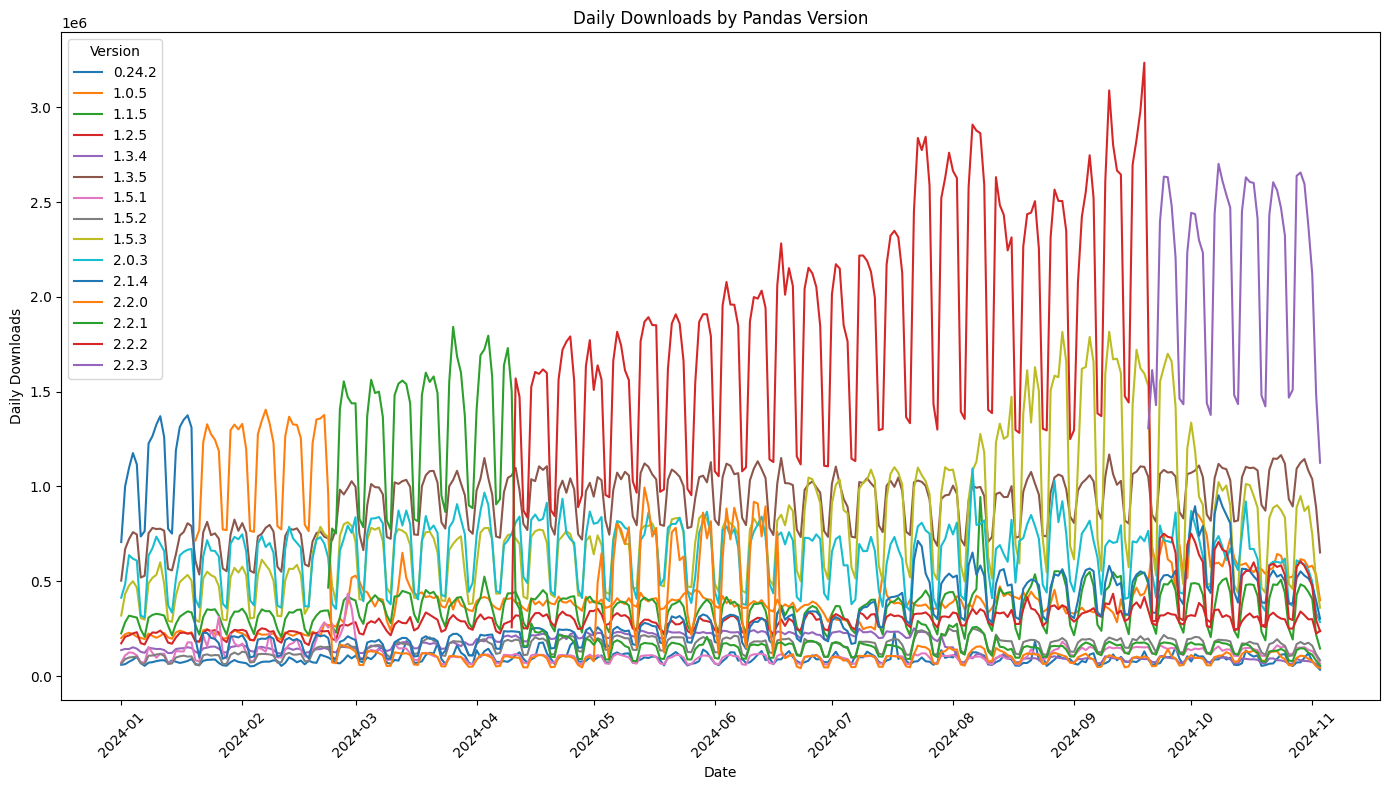

In [232]:
# Plot daily downloads by version
plt.figure(figsize=(14, 8))
for version in df_pandas_2024_top['library_version'].unique():
    version_data = df_pandas_2024_top[
        df_pandas_2024_top['library_version'] == version].groupby('date')['num_downloads'].sum().reset_index()
    plt.plot(version_data['date'], version_data['num_downloads'], label=version)

plt.xlabel('Date')
plt.ylabel('Daily Downloads')
plt.title('Daily Downloads by Pandas Version')
plt.legend(title='Version')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()